In [188]:
import pandas as pd
from matplotlib import pyplot

In [189]:
series = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv")
series = series.set_index(["Date"])

In [190]:
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


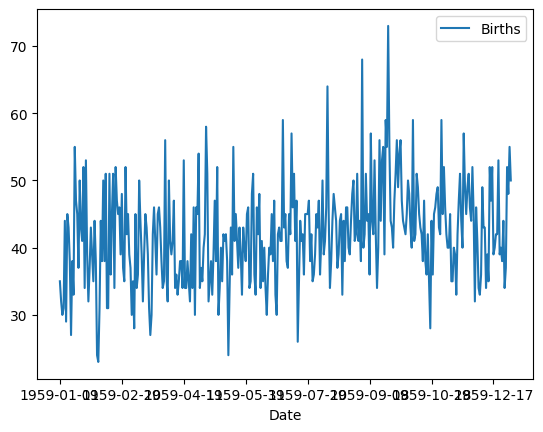

In [191]:
series.plot()
pyplot.show()

### Persistence forecast model - naive appraoch. 

What happend in past will happen in future! It will be a baseline model just to give a crude prediction. We can do complex models to predict this, but we can focus on this simple model first.



In [192]:
births_df = pd.DataFrame(series).rename(columns = {"Births": "births_t"})
births_df.head()

,births_t
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [193]:
births_df["births_t_min_1"] = births_df.births_t.shift(1).values
births_df = births_df.dropna()
births_df.head()

,births_t,births_t_min_1
Date,,
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0
1959-01-06,29,44.0


In [194]:
# split test train
from utils import utils as utils
train_df, test_df  = utils.split_to_train_test(births_df, 0.66)
train_df.head()
test_df.head()



,births_t,births_t_min_1
Date,,
1959-05-06,47,39.0
1959-05-07,38,47.0
1959-05-08,52,38.0
1959-05-09,30,52.0
1959-05-10,34,30.0


In [195]:
train_X = train_df.loc[:,"births_t_min_1"]
train_Y = train_df.loc[:,"births_t"]

test_X = test_df.loc[:,"births_t_min_1"]
test_Y = test_df.loc[:,"births_t"]

In [196]:
test_X

Date
1959-05-06    39.0
1959-05-07    47.0
1959-05-08    38.0
1959-05-09    52.0
1959-05-10    30.0
              ... 
1959-12-27    34.0
1959-12-28    37.0
1959-12-29    52.0
1959-12-30    48.0
1959-12-31    55.0
Name: births_t_min_1, Length: 240, dtype: float64

In [197]:
## Note we are just going to do naive predictions, i.e. just prediting next to be current one.
## So the test data is enough
predictions = test_X.shift(1)
predictions

Date
1959-05-06     NaN
1959-05-07    39.0
1959-05-08    47.0
1959-05-09    38.0
1959-05-10    52.0
              ... 
1959-12-27    44.0
1959-12-28    34.0
1959-12-29    37.0
1959-12-30    52.0
1959-12-31    48.0
Name: births_t_min_1, Length: 240, dtype: float64

In [198]:
test_Y

Date
1959-05-06    47
1959-05-07    38
1959-05-08    52
1959-05-09    30
1959-05-10    34
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: births_t, Length: 240, dtype: int64

In [199]:
pred_data_df = pd.concat([test_X, predictions], axis=1).set_axis(["births_t", "pred_births_t"], axis=1)
pred_data_df

,births_t,pred_births_t
Date,,
1959-05-06,39.0,NaN
1959-05-07,47.0,39.0
1959-05-08,38.0,47.0
1959-05-09,52.0,38.0
1959-05-10,30.0,52.0
...,...,...
1959-12-27,34.0,44.0
1959-12-28,37.0,34.0
1959-12-29,52.0,37.0


In [200]:
pred_data_df["residuals"] = pred_data_df["births_t"] - pred_data_df["pred_births_t"]
pred_data_df = pred_data_df.dropna()
pred_data_df

,births_t,pred_births_t,residuals
Date,,,
1959-05-07,47.0,39.0,8.0
1959-05-08,38.0,47.0,-9.0
1959-05-09,52.0,38.0,14.0
1959-05-10,30.0,52.0,-22.0
1959-05-11,34.0,30.0,4.0
...,...,...,...
1959-12-27,34.0,44.0,-10.0
1959-12-28,37.0,34.0,3.0
1959-12-29,52.0,37.0,15.0


In [201]:
# skill of persistence model
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(pred_data_df["births_t"], pred_data_df["pred_births_t"]))
rmse

8.78139913176124

In [202]:
train_df.head()

,births_t,births_t_min_1
Date,,
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0
1959-01-06,29,44.0


In [203]:
## We now have residual error which we can model

# Let us train on train dataset for errors
train_df.loc[:,"prediction"] = train_df["births_t_min_1"]
train_residual = train_df["births_t"] - train_df["prediction"]

## Auto regression of residual errors
train_residual

/var/folders/mw/pvq5xc9d1klbjmpfrl8cnwfm0000gn/T/ipykernel_2137/1581827051.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:,"prediction"] = train_df["births_t_min_1"]


Date
1959-01-02    -3.0
1959-01-03    -2.0
1959-01-04     1.0
1959-01-05    13.0
1959-01-06   -15.0
              ... 
1959-05-01   -19.0
1959-05-02     3.0
1959-05-03     3.0
1959-05-04    -5.0
1959-05-05     6.0
Length: 124, dtype: float64

In [204]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [205]:
selector = ar_select_order(train_residual, 15)

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [206]:
selector.ar_lags

[1, 2]

In [207]:
model = AutoReg(train_residual, lags=selector.ar_lags).fit()

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [208]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  124
Model:                     AutoReg(2)   Log Likelihood                -432.389
Method:               Conditional MLE   S.D. of innovations              8.375
Date:                Sat, 31 Aug 2024   AIC                            872.778
Time:                        16:25:22   BIC                            883.994
Sample:                    01-04-1959   HQIC                           877.334
                         - 05-05-1959                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0859      0.758      0.113      0.910      -1.400       1.572
y.L1          -0.6240      0.087     -7.193      0.000      -0.794      -0.454
y.L2          -0.2865      0.087     -3.301      0.001      -0.457      -0.116
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0889           -1.5181j            1.8682           -0.3490
AR.2           -1.0889           +1.5181j            1.8682            0.3490
-----------------------------------------------------------------------------
"""

Next, we can step through the test dataset and for each time step we must:
1. Calculate the persistence prediction.
2. Predict the residual error using the autoregression model.

In [209]:
# for test df
test_df.head()

,births_t,births_t_min_1
Date,,
1959-05-06,47,39.0
1959-05-07,38,47.0
1959-05-08,52,38.0
1959-05-09,30,52.0
1959-05-10,34,30.0


In [210]:
test_df.loc[:,"prediction_base"] = test_df["births_t_min_1"]

/var/folders/mw/pvq5xc9d1klbjmpfrl8cnwfm0000gn/T/ipykernel_2137/648385938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,"prediction_base"] = test_df["births_t_min_1"]


In [211]:
test_df.head()

,births_t,births_t_min_1,prediction_base
Date,,,
1959-05-06,47,39.0,39.0
1959-05-07,38,47.0,47.0
1959-05-08,52,38.0,38.0
1959-05-09,30,52.0,52.0
1959-05-10,34,30.0,30.0


In [212]:
test_df.loc[:,"error_base"] = test_df["births_t"].values - test_df["prediction_base"].values
test_df.head()

/var/folders/mw/pvq5xc9d1klbjmpfrl8cnwfm0000gn/T/ipykernel_2137/1968226751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,"error_base"] = test_df["births_t"].values - test_df["prediction_base"].values


,births_t,births_t_min_1,prediction_base,error_base
Date,,,,
1959-05-06,47,39.0,39.0,8.0
1959-05-07,38,47.0,47.0,-9.0
1959-05-08,52,38.0,38.0,14.0
1959-05-09,30,52.0,52.0,-22.0
1959-05-10,34,30.0,30.0,4.0


In [213]:
model.params

const    0.085930
y.L1    -0.623950
y.L2    -0.286517
dtype: float64

In [214]:
# rolling_error_values = 

test_df.error_base

Date
1959-05-06     8.0
1959-05-07    -9.0
1959-05-08    14.0
1959-05-09   -22.0
1959-05-10     4.0
              ... 
1959-12-27     3.0
1959-12-28    15.0
1959-12-29    -4.0
1959-12-30     7.0
1959-12-31    -5.0
Name: error_base, Length: 240, dtype: float64

In [215]:
#np.matrix(model.params).flip()
#
#const    0.085930
#y.L1    -0.623950
#y.L2    -0.286517
#

#0.085930 + (-0.623950) * (-9.0) +  (-0.286517) * (8.0)
#0.085930 + (-0.623950) *  14.0 +  (-0.286517) * (-9.0)

In [219]:
test_df

,births_t,births_t_min_1,prediction_base,error_base
Date,,,,
1959-05-06,47,39.0,39.0,8.0
1959-05-07,38,47.0,47.0,-9.0
1959-05-08,52,38.0,38.0,14.0
1959-05-09,30,52.0,52.0,-22.0
1959-05-10,34,30.0,30.0,4.0
...,...,...,...,...
1959-12-27,37,34.0,34.0,3.0
1959-12-28,52,37.0,37.0,15.0
1959-12-29,48,52.0,52.0,-4.0


In [217]:
def ar_pred(lag_vals, coeffs):
    a = np.array(lag_vals)
    a = np.insert(a, len(lag_vals), 1.0)
    #print(a)
    return sum(np.flip(model.params) * a)

coeffs = np.flip(np.array(model.params))
error_pred = test_df.error_base.rolling(2).apply(lambda s: ar_pred(s, coeffs))
error_pred
#test_df.loc[:,"error_pred"]
#test_df

Date
1959-05-06          NaN
1959-05-07     3.409351
1959-05-08    -6.070726
1959-05-09     9.801607
1959-05-10     3.893496
                ...    
1959-12-27     1.079246
1959-12-28   -10.132877
1959-12-29    -1.716018
1959-12-30    -3.135656
1959-12-31     1.200066
Name: error_base, Length: 240, dtype: float64

In [181]:
# Adjust for error
test_df.loc[:,"final_pred"] = test_df["prediction_base"] - test_df["error_pred"]
test_df

,births_t,births_t_min_1,prediction_base,error_base,error_pred,final_pred,final_error
Date,,,,,,,
1959-05-06,47,39.0,39.0,8.0,NaN,NaN,NaN
1959-05-07,38,47.0,47.0,-9.0,3.409351,43.590649,-12.409351
1959-05-08,52,38.0,38.0,14.0,-6.070726,44.070726,20.070726
1959-05-09,30,52.0,52.0,-22.0,9.801607,42.198393,-31.801607
1959-05-10,34,30.0,30.0,4.0,3.893496,26.106504,0.106504
...,...,...,...,...,...,...,...
1959-12-27,37,34.0,34.0,3.0,1.079246,32.920754,1.920754
1959-12-28,52,37.0,37.0,15.0,-10.132877,47.132877,25.132877
1959-12-29,48,52.0,52.0,-4.0,-1.716018,53.716018,-2.283982


In [182]:
test_df.loc[:,"final_error"] = test_df["births_t"] - test_df["final_pred"]
test_df

,births_t,births_t_min_1,prediction_base,error_base,error_pred,final_pred,final_error
Date,,,,,,,
1959-05-06,47,39.0,39.0,8.0,NaN,NaN,NaN
1959-05-07,38,47.0,47.0,-9.0,3.409351,43.590649,-5.590649
1959-05-08,52,38.0,38.0,14.0,-6.070726,44.070726,7.929274
1959-05-09,30,52.0,52.0,-22.0,9.801607,42.198393,-12.198393
1959-05-10,34,30.0,30.0,4.0,3.893496,26.106504,7.893496
...,...,...,...,...,...,...,...
1959-12-27,37,34.0,34.0,3.0,1.079246,32.920754,4.079246
1959-12-28,52,37.0,37.0,15.0,-10.132877,47.132877,4.867123
1959-12-29,48,52.0,52.0,-4.0,-1.716018,53.716018,-5.716018


<Axes: xlabel='Date'>

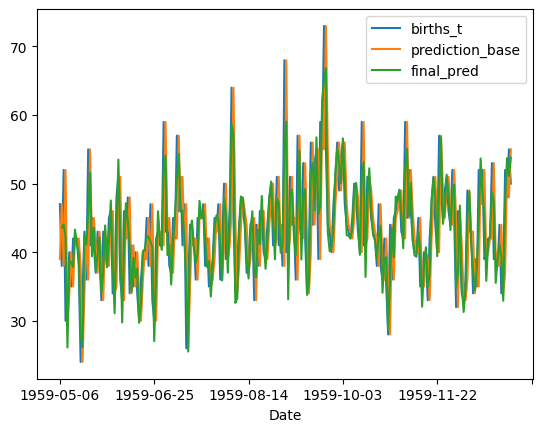

In [183]:
test_df[["births_t", "prediction_base", "final_pred"]].plot()

<Axes: xlabel='Date'>

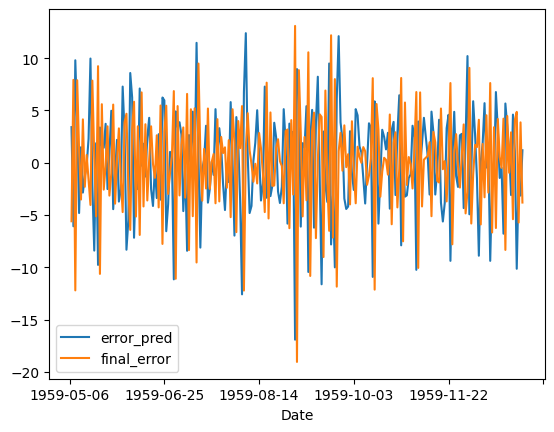

In [184]:
test_df[["error_pred", "final_error"]].plot()

In [187]:
test_df = test_df.dropna()
rmse_base = math.sqrt(mean_squared_error(test_df["births_t"], test_df["prediction_base"]))
rmse_final = math.sqrt(mean_squared_error(test_df["births_t"], test_df["final_pred"]))
print(f"rmse_base={rmse_base} rmse_final={rmse_final}")

rmse_base=8.772102985885374 rmse_final=4.972767811748761
